In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [1]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [2]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/29-34/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    in_chans = 12

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [3]:
def preprocess(image_stack, fragment_i, split_i):
    layer_num=image_stack.shape[2]
    for layer in range(layer_num):
        img=image_stack[:,:,layer]
        
        # フーリエ変換を実行
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)

        # ハイパスフィルタを作成
        rows, cols = img.shape
        crow, ccol = rows//2, cols//2
        mask = np.ones((rows, cols), np.uint8)
        r = 50  # ハイパスフィルタの半径
        center = [crow, ccol]
        x, y = np.ogrid[:rows, :cols]
        mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
        mask[mask_area] = 0

        # フィルタを適用
        fshift = fshift * mask

        # 逆フーリエ変換を実行して画像を復元
        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back).astype("float32")
        img_back=np.expand_dims(img_back, axis=-1)
        # percentile_95=np.percentile(img_back[:,:,6], 95)
        # img_clipped=np.clip(img_back, a_min=0, a_max=15000)*4
        image_stack=np.concatenate([image_stack, img_back], axis=-1).astype("float32")
    return image_stack


len(train_images) = 14624
train_images[0].shape = (224, 224, 12)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 12)
valid_labels[0].shape = (224, 224, 1)



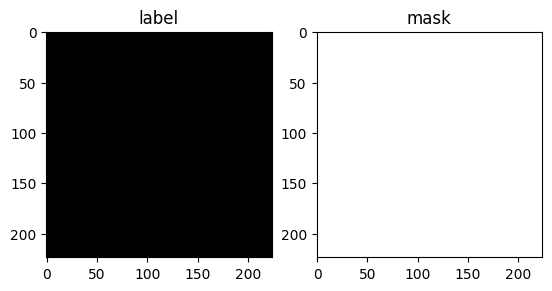

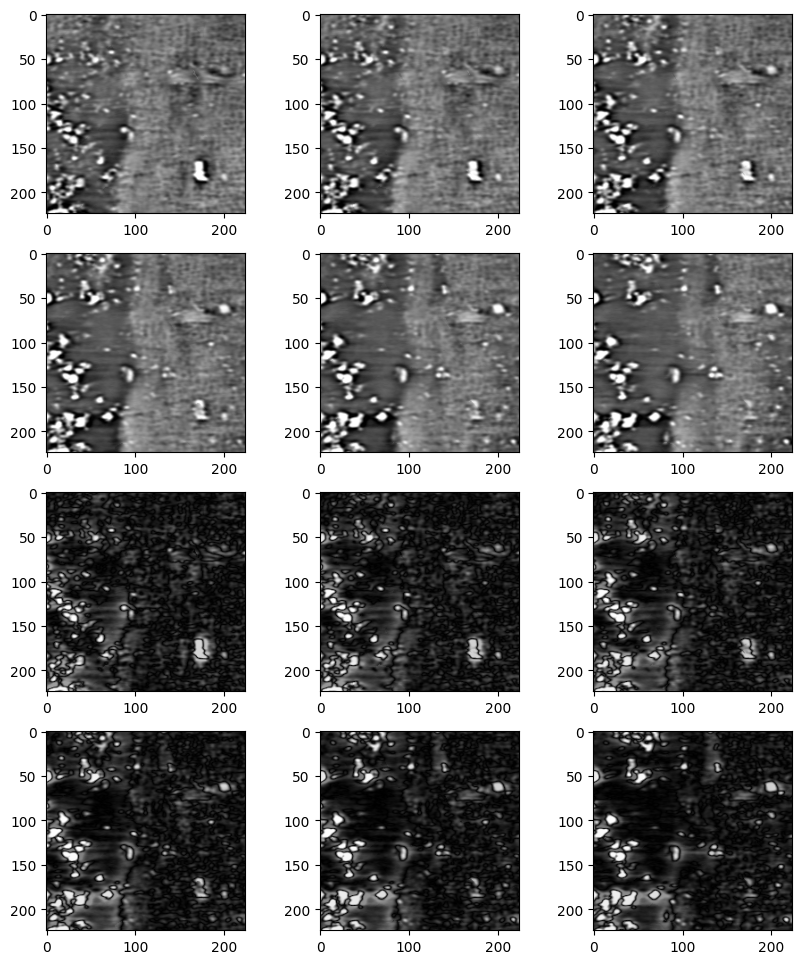

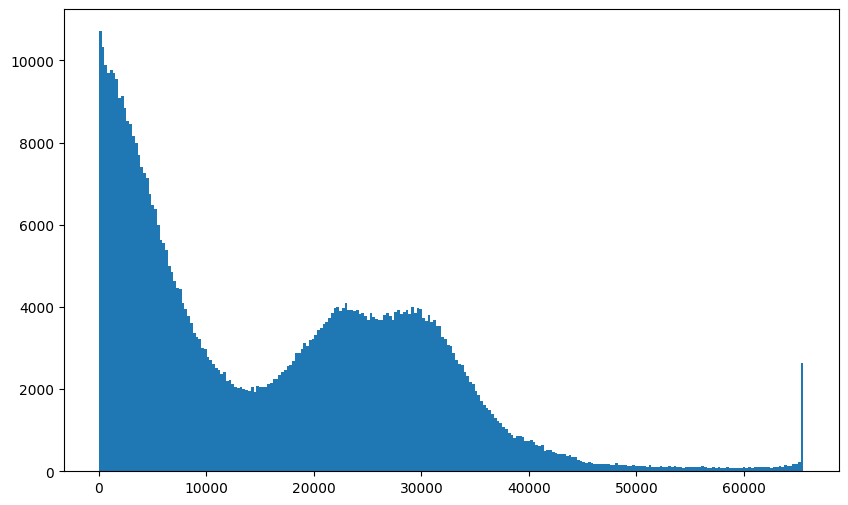

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


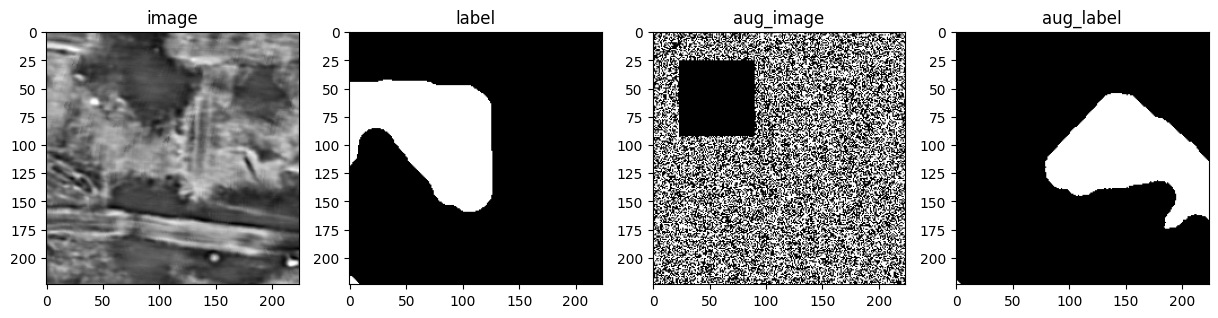

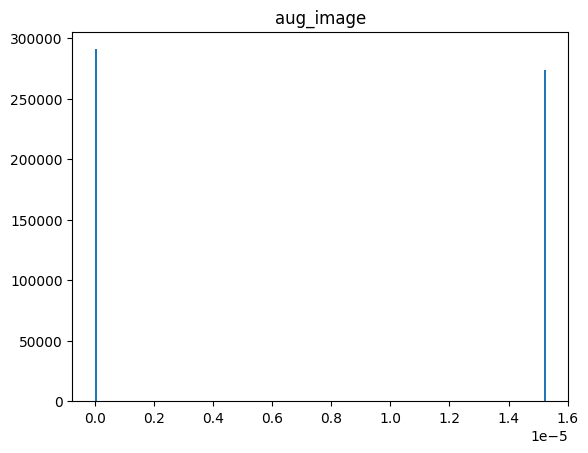

In [6]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [4]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|██████████| 131/131 [00:04<00:00, 26.70it/s]


fbeta: 0.0928
Epoch 1 - avg_train_loss: 0.5579  avg_val_loss: 0.3877  avgScore: 0.0928  time: 51s
Epoch 1 - Save Best Loss: 0.3877  Best Score: 0.0928 Model



100%|██████████| 131/131 [00:04<00:00, 30.46it/s]


fbeta: 0.0368
Epoch 2 - avg_train_loss: 0.3669  avg_val_loss: 0.3174  avgScore: 0.0368  time: 49s



100%|██████████| 131/131 [00:04<00:00, 30.28it/s]


fbeta: 0.0326
Epoch 3 - avg_train_loss: 0.3292  avg_val_loss: 0.2650  avgScore: 0.0326  time: 49s



100%|██████████| 131/131 [00:04<00:00, 30.30it/s]


fbeta: 0.0034
Epoch 4 - avg_train_loss: 0.3222  avg_val_loss: 0.2639  avgScore: 0.0034  time: 49s



100%|██████████| 131/131 [00:04<00:00, 30.31it/s]


fbeta: 0.0002
Epoch 5 - avg_train_loss: 0.3210  avg_val_loss: 0.2640  avgScore: 0.0002  time: 49s



100%|██████████| 131/131 [00:04<00:00, 30.06it/s]


fbeta: 0.0001
Epoch 6 - avg_train_loss: 0.3193  avg_val_loss: 0.2627  avgScore: 0.0001  time: 49s



 37%|███▋      | 337/914 [00:16<00:28, 20.44it/s]


KeyboardInterrupt: 

In [ ]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.5089
fbeta: 0.5594
fbeta: 0.5185
fbeta: 0.5974
fbeta: 0.5378


In [ ]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5440


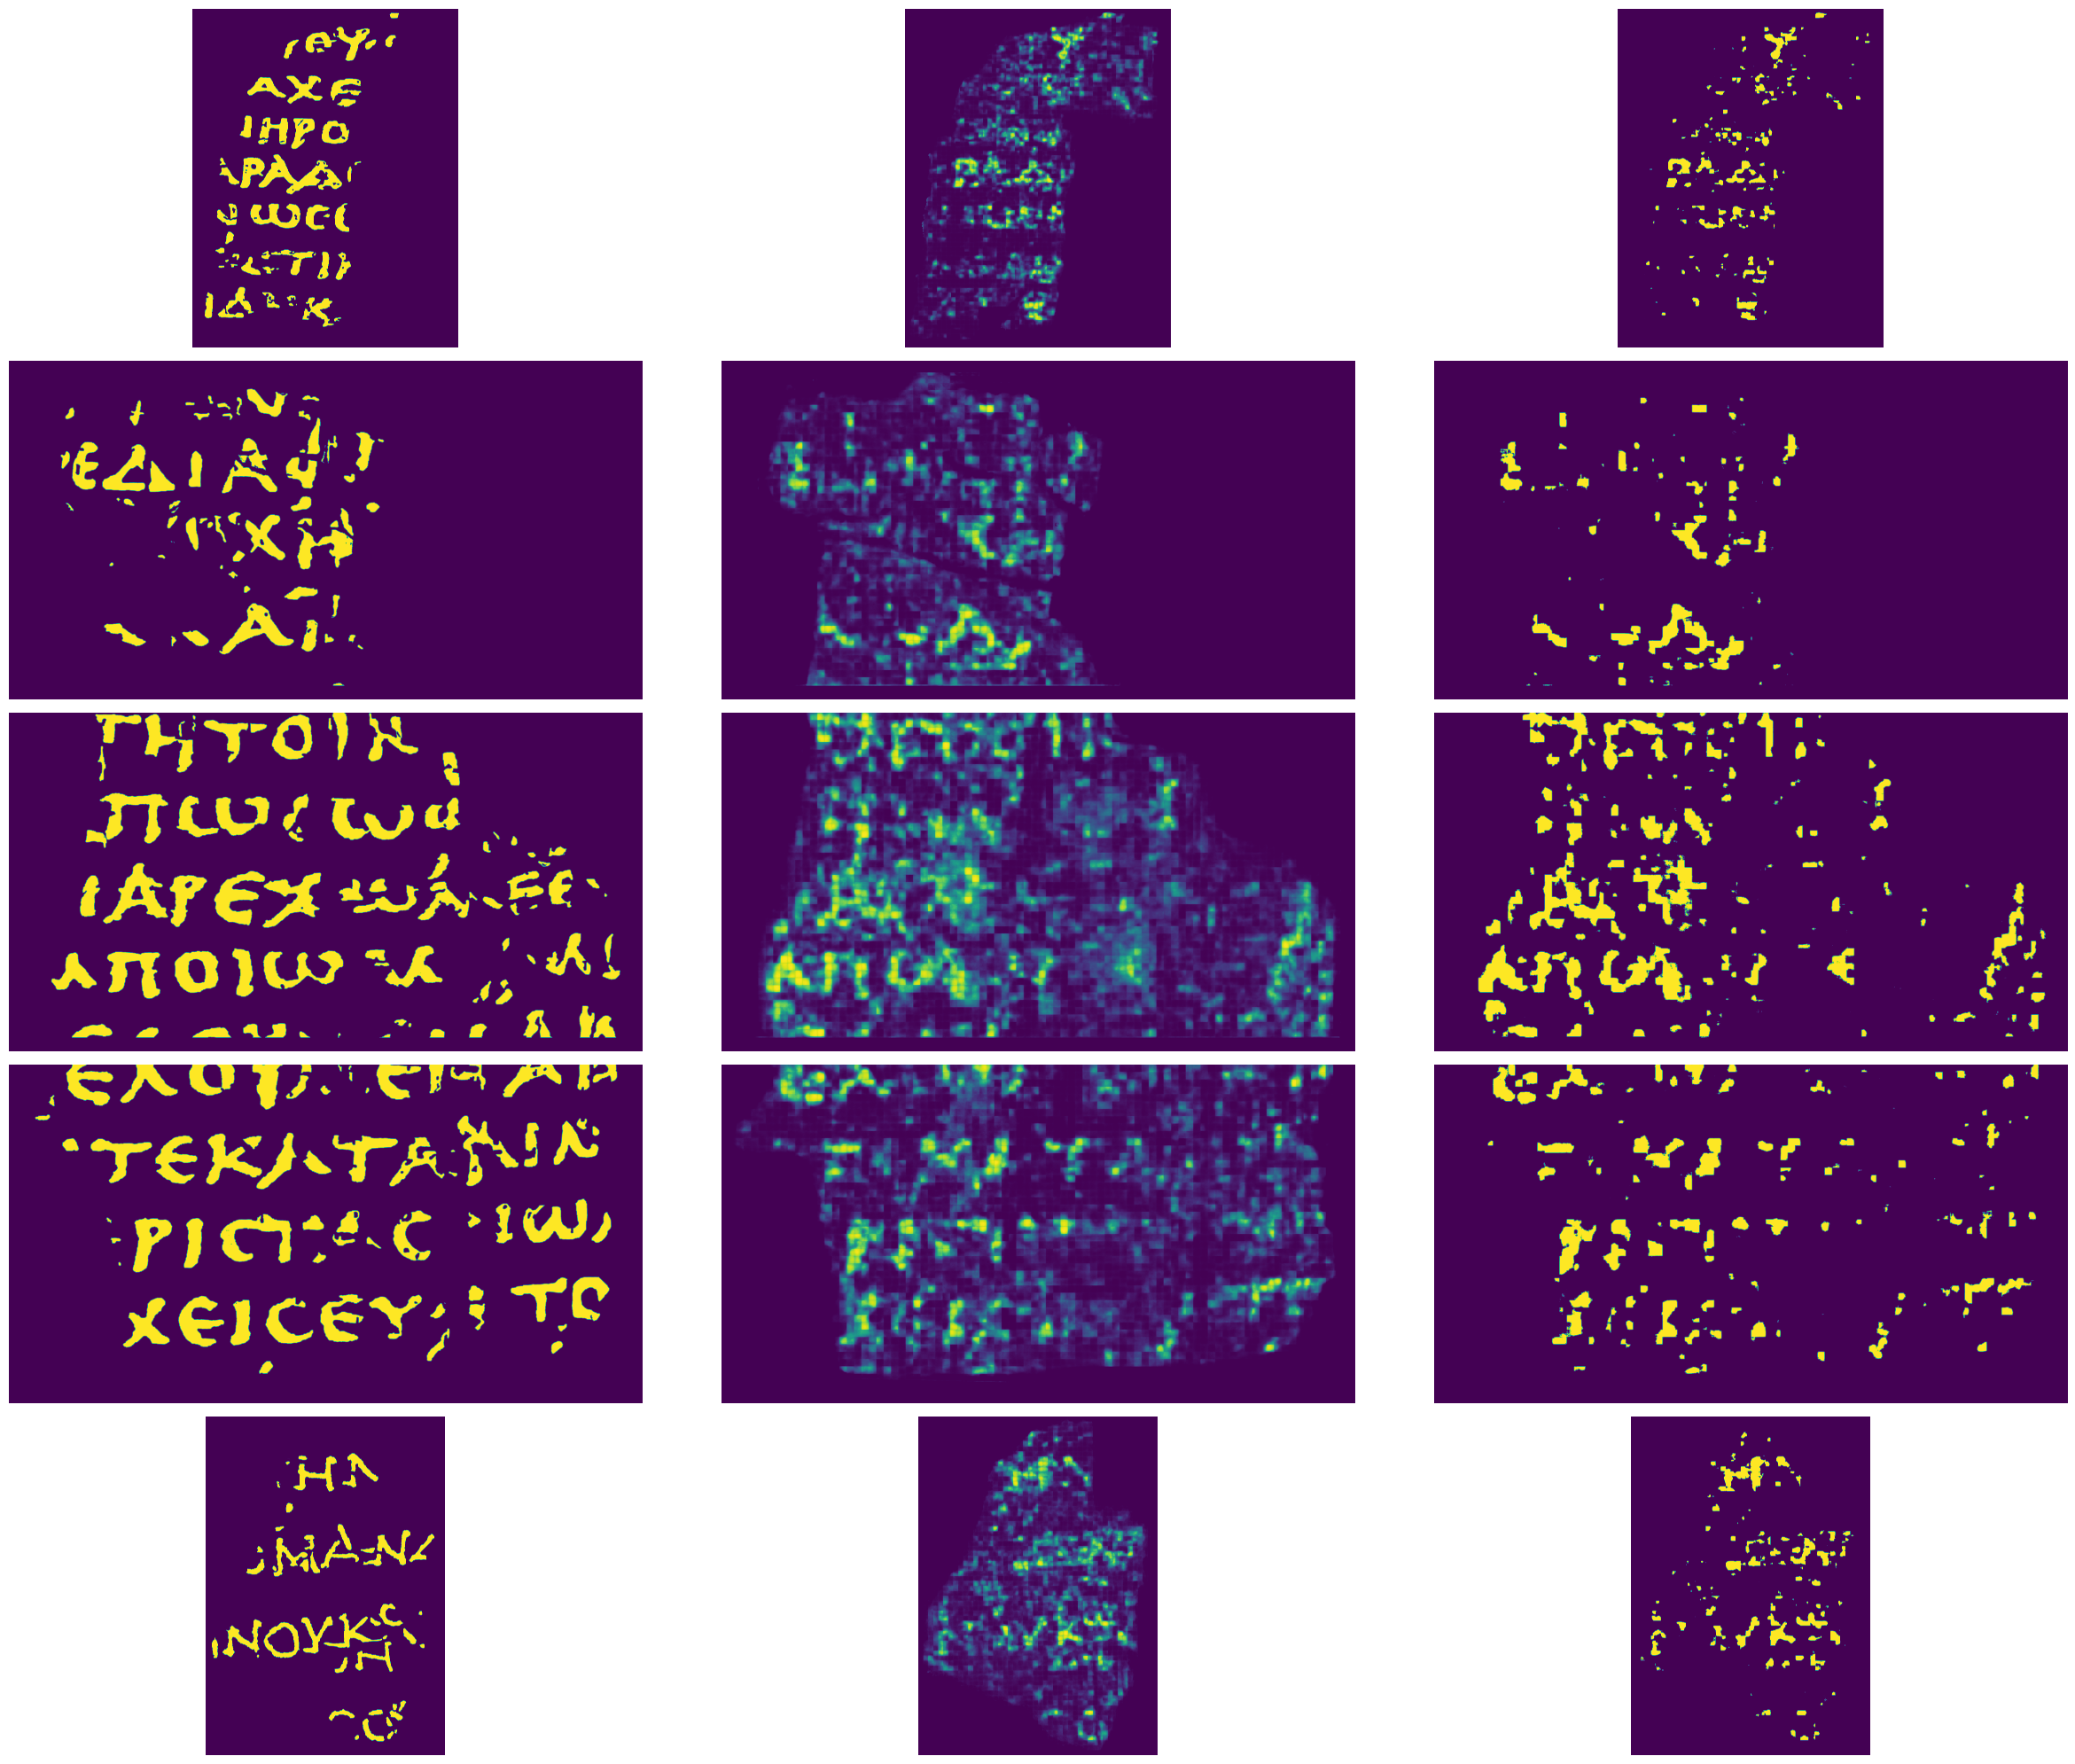

In [ ]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)